In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import random
import argparse
from tqdm import tqdm
import librosa
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from torchsummary import summary


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [3]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [4]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [5]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [6]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.72s


In [7]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [8]:
print(data_train.shape)

X_train, X_valid, y_train, y_valid = train_test_split(data_train, data_train_labels, stratify = data_train_labels, test_size = TEST_SPLIT_RATIO, random_state = SEED)   
X_test, y_test = data_test, data_test_labels

# Calculate the mean and standard deviation from the training data
mean_ = np.mean(X_train)
std_ = np.std(X_train)

# Apply the rescaling to the training, validation, and test data
X_train = (X_train - mean_) / std_
X_valid = (X_valid - mean_) / std_
X_test = (X_test - mean_) / std_

(10316, 4000)


In [9]:
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(7737, 2579, 2580, 7737, 2579, 2580)

In [10]:
# balance
y_train.sum(), len(y_train) - y_train.sum()

(3869, 3868)

In [11]:
y_valid.sum(), len(y_valid) - y_valid.sum()

(1289, 1290)

In [12]:
y_test.sum(), len(y_test) - y_test.sum()

(1290, 1290)

In [13]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

In [14]:
test = np.arange(20)
print(test.shape, test)
test_out = random_data_shift(test)
print(test_out.shape,test_out)

(20,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,) [18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [15]:
class AugmentedDataset(Dataset):
    def __init__(self, inputs, targets, augment=False):
        self.inputs = inputs
        self.targets = targets
        
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        
        if self.augment:
            sample = random_data_shift(sample)
        
        data = sample.copy()
        
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, shuffle=True, augment=False):
    dataset = AugmentedDataset(inputs, targets, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [16]:
train_loader = create_dataloader(X_train, y_train, BATCH_SIZE, shuffle=True, augment=AUGM)
valid_loader = create_dataloader(X_valid, y_valid, BATCH_SIZE, shuffle=False, augment=False) 
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE, shuffle=False, augment=False) 


In [17]:
EVAL_FREQ = len(train_loader)//EVAL_FREQ

In [18]:
print(len(train_loader), EVAL_FREQ)

242 60


In [19]:
for x, y in train_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 4000]) torch.Size([32, 1])


In [20]:
for x, y in valid_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 4000]) torch.Size([32, 1])


# Model

In [21]:
################################################################
#  Residual Block
################################################################
class ResidualBlock(nn.Module):
    """
    A residual block
    """

    def __init__(self, channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
                                   
        self.conv1 = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=True)
        self.conv2 = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=True)
        
        self.bn1 = nn.BatchNorm1d(num_features=channels)
        self.bn2 = nn.BatchNorm1d(num_features=channels)
        
    def forward(self, x):
        residual = x
        
        out = F.gelu(self.conv1(x))
        out = self.bn1(out)
        
        out = F.gelu(self.conv2(out))
        out = self.bn2(out)
        
        out = out + residual
        
        return out

##########################
# Small Resnet9
##########################
class ResNet9_small(nn.Module):
    """
    A Residual network.
    """
    def __init__(self,pool_size=2,kernel_size=11):
        super(ResNet9_small, self).__init__()
        
        self.pool_size = pool_size
        self.kernel_size = kernel_size
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.rb1 = ResidualBlock(channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=96, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)
        self.bn3 = nn.BatchNorm1d(num_features=96)
        
        self.conv4 = nn.Conv1d(in_channels=96, out_channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        
        self.rb2 = ResidualBlock(channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2)

        self.gap = torch.nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(in_features=128, out_features = 1, bias=True)

    def forward(self, x):
        x = x[:,None,:]
        batch_size = len(x)
        
        
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = F.gelu(x)
        x = self.bn2(x)
        
        ##################
        # 1st residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb1(x)
        
        x = self.conv3(x)
        x = F.gelu(x)
        x = self.bn3(x)
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        
        x = self.conv4(x)
        x = F.gelu(x)
        x = self.bn4(x)
        
        ##################
        # 2nd residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb2(x)
                
        x = self.gap(x)
        x = x.view(batch_size,-1)
        
        
        out = self.fc(x)
        
        return out

In [22]:
model = ResNet9_small()
#model.to(device)

# Utilities

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [24]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation

## Accuracies and losses



In [25]:
epoch_df = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{0}.csv",sep=";")
epoch_df = epoch_df.drop_duplicates(subset=['epoch'], keep='first')
epoch_df = epoch_df.drop(["valid_loss","valid_acc"], axis=1)
epoch_df["epoch"] = epoch_df["epoch"].astype(str)
df_new = epoch_df.set_index("epoch")
for i in range(5):
    df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_valid = df_valid.rename(columns={"valid_loss":f"valid_loss_{i}","valid_acc":f"valid_acc_{i}"})
    df_valid["epoch"] = df_valid["epoch"].astype(str)
    df_valid = df_valid.drop_duplicates(subset=['epoch'], keep='first')
    df_valid = df_valid.set_index("epoch")
    df_new = df_new.join(df_valid)


In [26]:
df_new = df_new.reset_index()
df_new["epoch"] = df_new["epoch"].astype(float)

df_new["valid_loss_max"]=df_new[[f"valid_loss_{i}" for i in range(5)]].max(axis=1)
df_new["valid_loss_min"]=df_new[[f"valid_loss_{i}" for i in range(5)]].min(axis=1)
df_new["valid_loss_mean"]=df_new[[f"valid_loss_{i}" for i in range(5)]].mean(axis=1)

df_new["valid_acc_max"]=df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=1)
df_new["valid_acc_min"]=df_new[[f"valid_acc_{i}" for i in range(5)]].min(axis=1)
df_new["valid_acc_mean"]=df_new[[f"valid_acc_{i}" for i in range(5)]].mean(axis=1)

In [27]:
df_new

,epoch,valid_loss_0,valid_acc_0,valid_loss_1,valid_acc_1,valid_loss_2,valid_acc_2,valid_loss_3,valid_acc_3,valid_loss_4,valid_acc_4,valid_loss_max,valid_loss_min,valid_loss_mean,valid_acc_max,valid_acc_min,valid_acc_mean
0,0.247934,0.555578,72.353625,0.555054,72.702598,0.556260,71.733230,0.566333,69.445522,0.593800,66.072121,0.593800,0.555054,0.565405,72.702598,66.072121,70.461419
1,0.495868,0.526400,73.788290,0.521160,74.020938,0.520487,73.633191,0.518839,74.020938,0.559626,72.159752,0.559626,0.518839,0.529303,74.020938,72.159752,73.524622
2,0.743802,0.513286,74.369911,0.501305,75.533152,0.503822,75.882125,0.503999,74.912757,0.533274,73.245444,0.533274,0.501305,0.511137,75.882125,73.245444,74.788678
3,0.991736,0.510509,74.641334,0.487295,76.851493,0.502118,77.859636,0.498741,76.851493,0.526928,74.331136,0.526928,0.487295,0.505118,77.859636,74.331136,76.107018
4,1.000000,0.509191,74.796433,0.488896,76.386196,0.500600,77.820861,0.495788,76.463746,0.543784,74.214812,0.543784,0.488896,0.507652,77.820861,74.214812,75.936409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.247934,0.387937,84.218689,0.386483,84.141140,0.406014,82.784025,0.400807,82.939124,0.419550,81.543234,0.419550,0.386483,0.400158,84.218689,81.543234,83.125242
96,19.495868,0.385228,84.645211,0.381518,84.761535,0.395517,83.947266,0.396265,83.520744,0.408615,82.628926,0.408615,0.381518,0.393429,84.761535,82.628926,83.900737
97,19.743802,0.384617,84.567662,0.379097,84.800310,0.392265,83.830942,0.393652,83.792168,0.403646,83.210547,0.403646,0.379097,0.390655,84.800310,83.210547,84.040326
98,19.991736,0.385472,84.606437,0.377946,84.839085,0.391350,83.830942,0.393206,83.792168,0.401879,83.288096,0.401879,0.377946,0.389971,84.839085,83.288096,84.071345


In [28]:
EPOCHS = np.max(df_new["epoch"].values).astype(int)
epochs_train = np.arange(1,EPOCHS+1)
df_new_train = pd.DataFrame({"epoch":epochs_train})
df_new_train = df_new_train.set_index("epoch")

for i in range(5):
    df_train = pd.read_csv(f"{TRAIN_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_train = df_train.rename(columns={"train_loss":f"train_loss_{i}","train_acc":f"train_acc_{i}"})
    
    df_train = df_train.set_index("epoch")
    df_new_train = df_new_train.join(df_train)

df_new_train["train_loss_max"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_loss_min"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_loss_mean"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].mean(axis=1)

df_new_train["train_acc_max"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_acc_min"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_acc_mean"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].mean(axis=1)
df_new_train = df_new_train.reset_index()

In [29]:
df_new_train

,epoch,train_loss_0,train_acc_0,train_loss_1,train_acc_1,train_loss_2,train_acc_2,train_loss_3,train_acc_3,train_loss_4,train_acc_4,train_loss_max,train_loss_min,train_loss_mean,train_acc_max,train_acc_min,train_acc_mean
0,1,0.490707,75.106630,0.473438,76.696394,0.489478,77.368489,0.480310,76.515445,0.540038,73.878764,0.540038,0.473438,0.494794,77.368489,73.878764,75.913145
1,2,0.457290,78.712679,0.451985,79.384774,0.456521,78.118134,0.457892,78.247383,0.463081,77.536513,0.463081,0.451985,0.457354,79.384774,77.536513,78.399897
2,3,0.437411,79.979320,0.453354,79.022877,0.432922,80.056870,0.475483,78.467106,0.444265,79.022877,0.475483,0.432922,0.448687,80.056870,78.467106,79.309810
3,4,0.431743,81.375210,0.425465,80.509241,0.415581,81.194261,0.426265,80.909913,0.433392,80.496316,0.433392,0.415581,0.426489,81.375210,80.496316,80.896988
4,5,0.411573,81.439835,0.402653,81.375210,0.407453,81.918056,0.415427,81.039162,0.423039,80.845289,0.423039,0.402653,0.412029,81.918056,80.845289,81.323510
5,6,0.400892,82.034380,0.400126,81.853432,0.396027,82.447977,0.418693,81.969756,0.424951,81.220111,0.424951,0.396027,0.408138,82.447977,81.220111,81.905131
6,7,0.388539,82.900349,0.390582,83.081298,0.389030,83.326871,0.402989,82.784025,0.399208,83.055448,0.402989,0.388539,0.394070,83.326871,82.784025,83.029598
7,8,0.394990,82.021455,0.386931,83.094223,0.401134,82.357503,0.386016,83.107147,0.409551,81.271811,0.409551,0.386016,0.395724,83.107147,81.271811,82.370428
8,9,0.379338,84.335014,0.368698,84.735686,0.378664,83.766318,0.381932,82.874499,0.389874,83.132997,0.389874,0.368698,0.379701,84.735686,82.874499,83.768903
9,10,0.380672,83.779243,0.366163,84.735686,0.378438,83.637069,0.380500,83.921417,0.391300,83.107147,0.391300,0.366163,0.379415,84.735686,83.107147,83.836112


In [30]:
SMALL_SIZE = 15
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

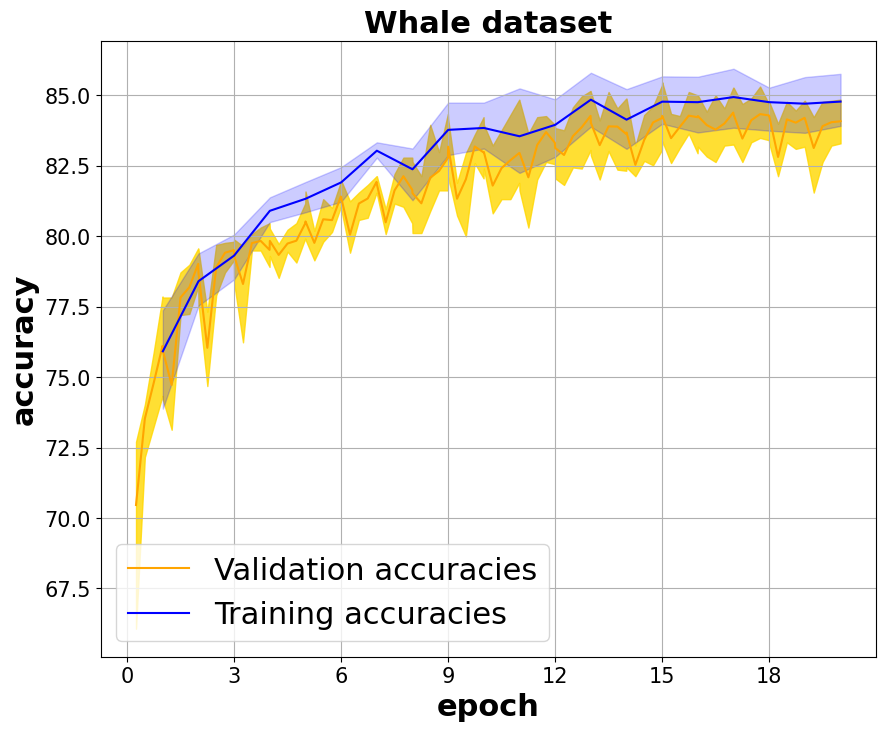

In [31]:
# Accuracies
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_acc_mean"], 'orange',label="Validation accuracies")
ax.fill_between(df_new["epoch"], df_new["valid_acc_min"],df_new["valid_acc_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_acc_mean"], 'b-',label="Training accuracies")
ax.fill_between(df_new_train["epoch"], df_new_train["train_acc_min"],df_new_train["train_acc_max"], color='b', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("accuracy",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('sr9_accuracies.svg', format='svg')


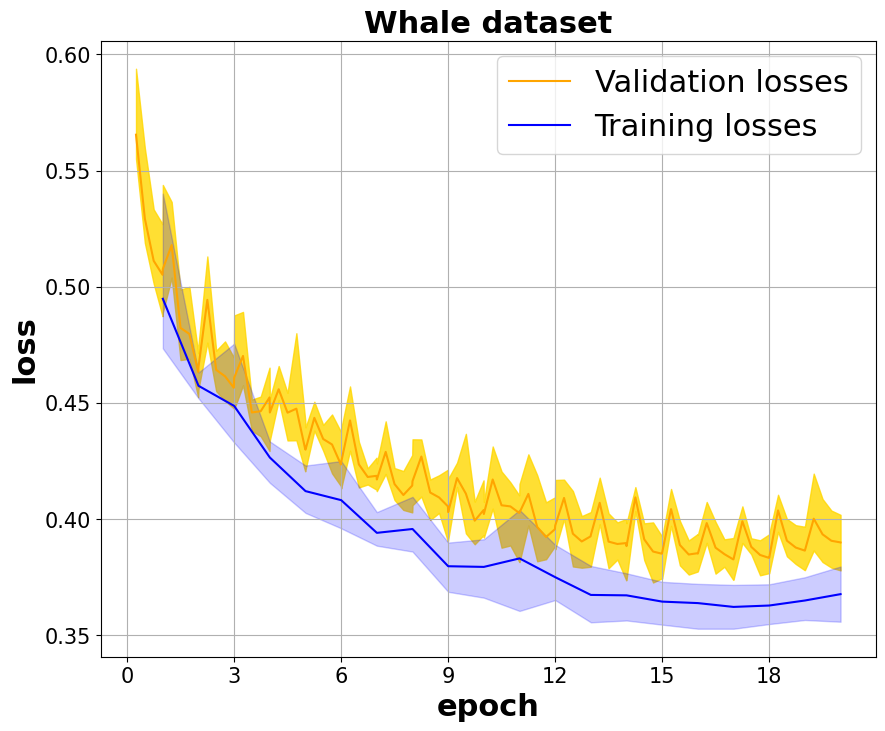

In [32]:
# Losses
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_loss_mean"], 'orange',label="Validation losses")
ax.fill_between(df_new["epoch"], df_new["valid_loss_min"],df_new["valid_loss_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_loss_mean"], 'b-',label="Training losses")
ax.fill_between(df_new_train["epoch"], df_new_train["train_loss_min"],df_new_train["train_loss_max"], color='b', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold")
plt.ylabel("loss",weight="bold")
plt.legend()
plt.grid()
plt.title(f"Whale dataset",fontsize=22,weight="bold")
plt.show(block=False)
fig.savefig('sr9_losses.svg', format='svg')

## The best model

In [33]:
# The model with the best validation accuracy
IND = np.argmax(df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=0).values)
IND

1

In [34]:
state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{IND}.pt")

In [35]:
model = ResNet9_small()

In [36]:
model.load_state_dict(state_dict)
model.to(device)
print(f"Number of the parameters: {count_parameters(model)}\n")
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)

train_loss, train_acc = evaluate(model, train_loader, criterion, device)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(160*"-"+"\n")
print(f"The model with the best validation accuracy:")
print(f'Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t\n')

Number of the parameters: 678433

----------------------------------------------------------------------------------------------------------------------------------------------------------------

The model with the best validation accuracy:
Train Loss: 0.355 -  Train Acc: 85.67% | Valid Loss: 0.374 - Valid Acc: 85.46% | Test Loss: 0.377 - Test Acc: 84.92% 	



In [37]:
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_true.append(y.view(-1,1))

        x = x.to(device)
        y = y.to(device)
                
        y_pred = model(x)
            
        top_pred = (torch.sigmoid(y_pred) > 0.5).int()
        y_preds.append(top_pred.detach().cpu().view(-1,1))

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)
results = classification_report(y_true, y_preds, target_names=target_names,output_dict=True)
print(pd.DataFrame(results).T,"\n")

              precision    recall  f1-score      support
no-whale       0.816140  0.901550  0.856722  1290.000000
whale          0.890043  0.796899  0.840900  1290.000000
accuracy       0.849225  0.849225  0.849225     0.849225
macro avg      0.853092  0.849225  0.848811  2580.000000
weighted avg   0.853092  0.849225  0.848811  2580.000000 



In [38]:
# Recall accuracy 
recall_score(y_true,y_preds)

0.7968992248062016

## Confusion matrix

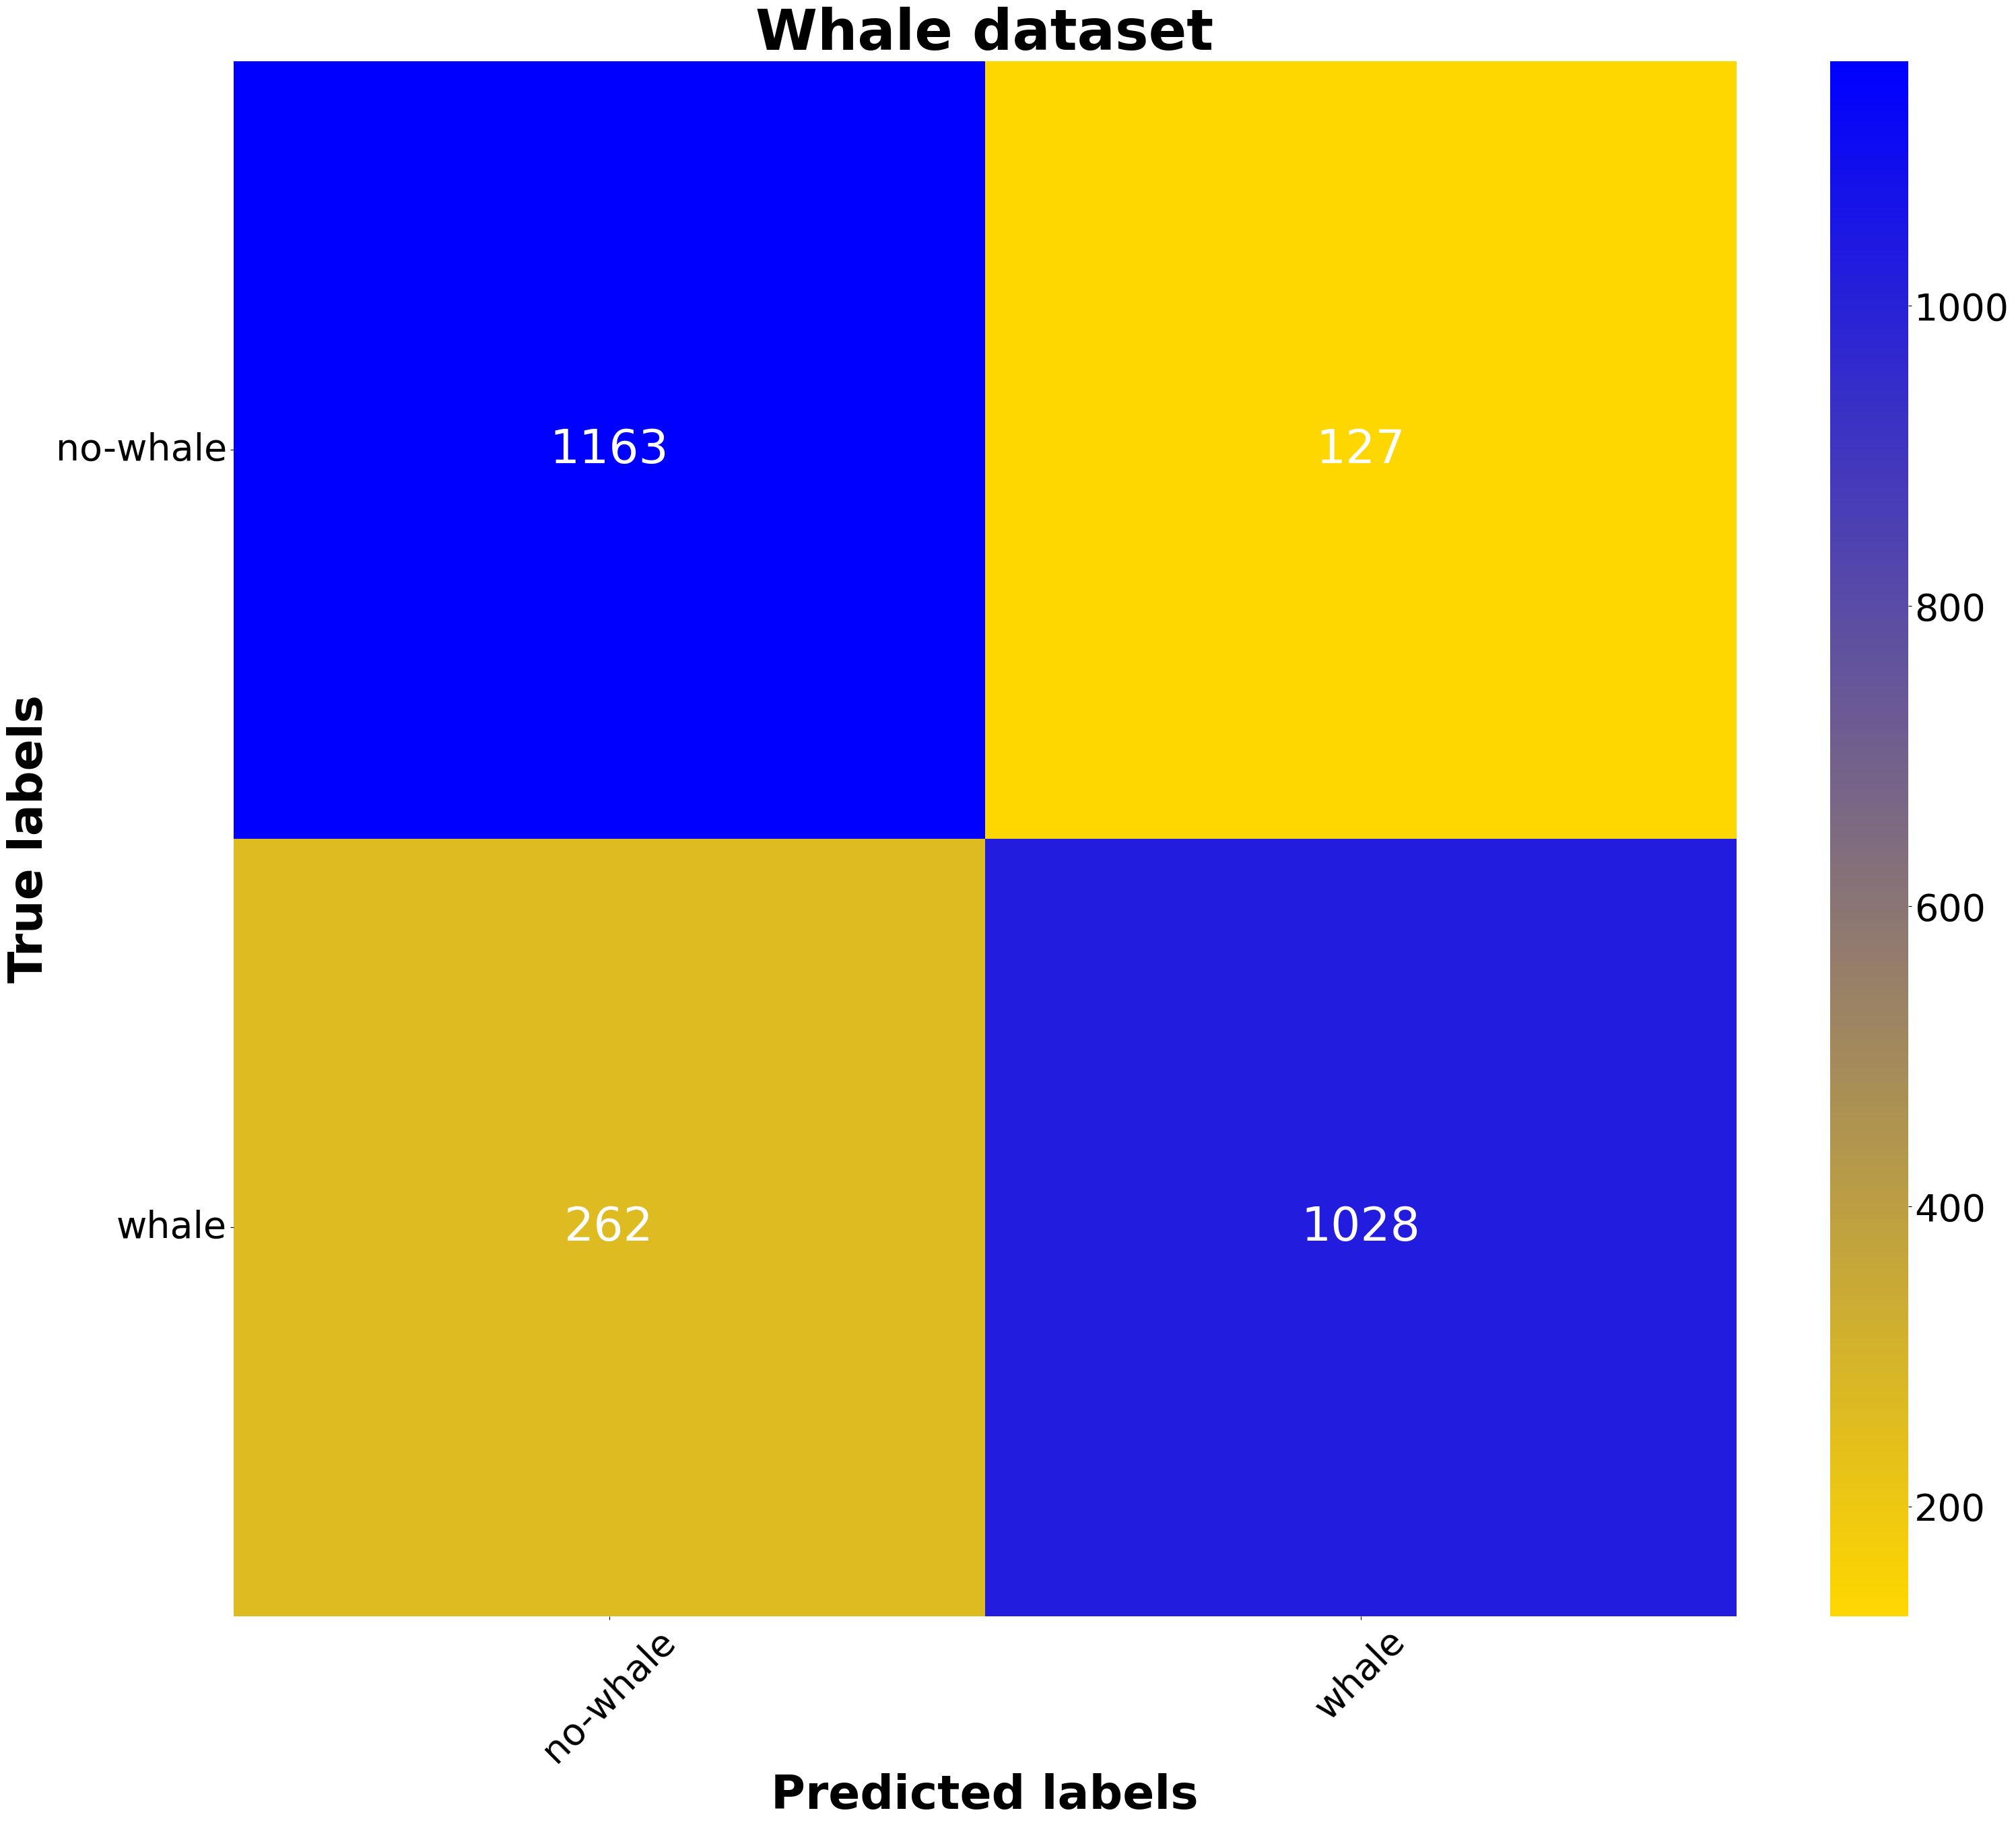

In [39]:
cm = confusion_matrix(y_true, y_preds, labels=list(range(len(target_names))))

# Adjust font sizes and styles
SMALL_SIZE = 50
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title is effectively disabled
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize is effectively disabled
plt.rc('figure', titlesize=0)  # fontsize of the figure title is effectively disabled

# Create a custom colormap from gold to blue
gold_blue_cmap = LinearSegmentedColormap.from_list("gold_blue_cmap", ["gold", "blue"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_blue_cmap, ax=ax, annot_kws={"color": "white"})

# Set axis labels and titles
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Title setup
plt.title("Whale dataset", fontsize=60, weight="bold")

# Display the plot
plt.show()

# Save the figure
fig.savefig('sr9_cm.svg', format='svg')


## Accuracies among the 5 models

In [40]:
final_results = {"train_losses":[],
                 "train_accuracies":[],
                 "valid_losses":[],
                 "valid_accuracies":[],
                 "test_losses":[],
                 "test_accuracies":[],
                 "test_recalls":[]}

In [41]:
for ind in range(5):
    model = ResNet9_small()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{ind}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    final_results["train_losses"].append(train_loss)
    final_results["train_accuracies"].append(train_acc)
    
    final_results["valid_losses"].append(valid_loss)
    final_results["valid_accuracies"].append(valid_acc)
    
    final_results["test_losses"].append(test_loss)
    final_results["test_accuracies"].append(test_acc)
    
    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_true.append(y.view(-1,1))

            x = x.to(device)
            y = y.to(device)
                
            y_pred = model(x)
            
            top_pred = (torch.sigmoid(y_pred) > 0.5).int()
            y_preds.append(top_pred.detach().cpu().view(-1,1))

        y_preds = torch.cat(y_preds)
        y_true = torch.cat(y_true)
    test_recall = recall_score(y_true,y_preds)
    
    final_results["test_recalls"].append(test_recall)
    
    print(f'Model {ind} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')

Model 0 | Train Loss: 0.361 -  Train Acc: 85.29% | Valid Loss: 0.385 - Valid Acc: 85.19% | Test Loss: 0.386 - Test Acc: 83.76% 	
Model 1 | Train Loss: 0.355 -  Train Acc: 85.67% | Valid Loss: 0.374 - Valid Acc: 85.46% | Test Loss: 0.377 - Test Acc: 84.92% 	
Model 2 | Train Loss: 0.366 -  Train Acc: 85.12% | Valid Loss: 0.393 - Valid Acc: 85.15% | Test Loss: 0.395 - Test Acc: 84.19% 	
Model 3 | Train Loss: 0.374 -  Train Acc: 84.80% | Valid Loss: 0.396 - Valid Acc: 84.41% | Test Loss: 0.395 - Test Acc: 83.99% 	
Model 4 | Train Loss: 0.373 -  Train Acc: 84.01% | Valid Loss: 0.391 - Valid Acc: 83.64% | Test Loss: 0.394 - Test Acc: 83.22% 	


In [42]:
print(f"Mean test accuracy: {np.mean(final_results['test_accuracies']):.4f}")
print(f"Mean test recall: {np.mean(final_results['test_recalls']):.4f}")

Mean test accuracy: 0.8402
Mean test recall: 0.7848


In [43]:
pd.DataFrame(y_test).value_counts()

0    1290
1    1290
Name: count, dtype: int64

In [44]:
data_test = pd.read_csv(TEST_DATASET,sep=",")
#columns = data_test.columns
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]